# Part 1: Preprocessing

In [ ]:
!gdown --id 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz
!tar xzf CIFAR10.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g
To: /content/CIFAR10.tar.gz
100% 19.8M/19.8M [00:00<00:00, 281MB/s]


## Import libraries

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import time

## Show first image from each class

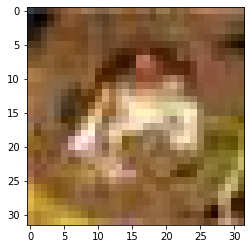

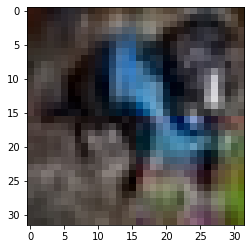

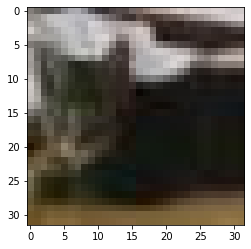

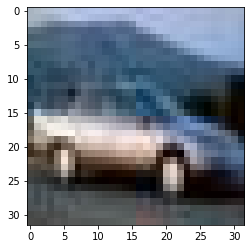

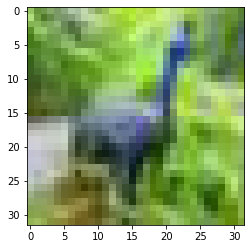

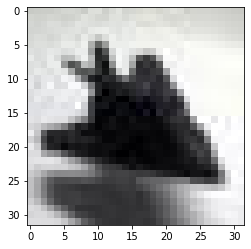

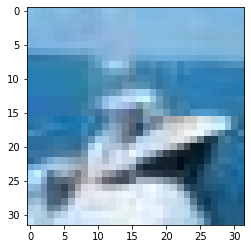

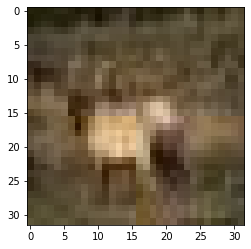

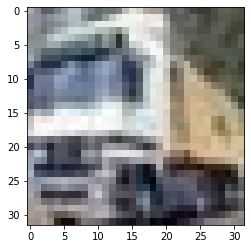

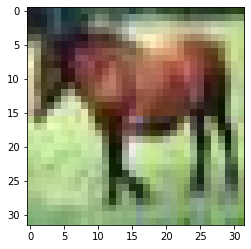

In [ ]:
for path in glob.glob('./CIFAR10/train/*'):
  img = mpimg.imread(path + '/0000.jpg')
  imgplot = plt.imshow(img)
  plt.show()


## Read data samples and labels

In [ ]:
dataSets = ['airplane', 'automobile', 'bird', 'cat']

def readSamples(path, dataSets, dataSetLen):
  images = []
  labels = []
  i = 0
  for dataSet in dataSets:
    for imagePath in glob.glob(path + dataSet + '/*.jpg'):
      img = mpimg.imread(imagePath)
      label = np.zeros(shape=(dataSetLen,))
      label[i] = 1
      images.append(img)
      labels.append(label)
    i += 1
  return np.array(images), np.array(labels).reshape(-1, 4, 1)

trainSamples, trainLabels = readSamples('./CIFAR10/train/', dataSets, len(dataSets))
testSamples, testLabels = readSamples('./CIFAR10/test/', dataSets, len(dataSets))

## Print examples of data sets

In [ ]:
print(trainSamples.shape)
print(trainLabels.shape)

(20000, 32, 32, 3)
(20000, 4, 1)


## Convert RGB to grayscale

In [ ]:
def rgb2gray(rgb):
  r, g, b = rgb[:, :, :, 0], rgb[:, :, :,1], rgb[:, :, :, 2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

grayTrain = rgb2gray(trainSamples)
grayTest = rgb2gray(testSamples)

In [ ]:
print(grayTrain[0][0][0])

242.1436


## Divide by 255

In [ ]:
normalizedTrain = np.divide(grayTrain, 255)
normalizedTest = np.divide(grayTest, 255)

In [ ]:
print(normalizedTrain[0][0][0])

0.9495827450980392


## Flaten arrays to (n_sample, 1024)

In [ ]:
train = normalizedTrain.reshape(-1, 1024, 1)
test = normalizedTest.reshape(-1, 1024, 1)

In [ ]:
print(train.shape)

(20000, 1024, 1)


## Shuffle data set and labels in unison

In [ ]:
def unisonShuffled(a, b):
    p = np.random.permutation(len(a))
    return a[p], b[p]

shuffledTrain, shuffledTrainLables = unisonShuffled(train, trainLabels)

In [ ]:
print(shuffledTrain.shape)
print(shuffledTrainLables.shape)

(20000, 1024, 1)
(20000, 4, 1)


# Part 2: Feedforward

## Define sigmoid and initialize weights, biases, gradian of weights, gradian of biases

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

w = []
b = []
grad_w = []
grad_b = []

def initializeWeightBias():
  global w
  global b
  w = []
  b = []
  # layer 1
  w.append(np.random.normal(size=(16, 1024)))
  b.append(np.zeros((16, 1)))
  # layer 2
  w.append(np.random.normal(size=(16, 16)))
  b.append(np.zeros((16, 1)))
  # layer 3
  w.append(np.random.normal(size=(4, 16)))
  b.append(np.zeros((4, 1)))

def initializeGradians():
  global grad_w
  global grad_b
  grad_w = []
  grad_b = []
  # layer 1
  grad_w.append(np.zeros((16, 1024)))
  grad_b.append(np.zeros((16, 1)))
  # layer 2
  grad_w.append(np.zeros((16, 16)))
  grad_b.append(np.zeros((16, 1)))
  # layer 3
  grad_w.append(np.zeros((4, 16)))
  grad_b.append(np.zeros((4, 1)))

def feedforward(a0, y):
  a1 = sigmoid(w[0] @ a0 + b[0])
  a2 = sigmoid(w[1] @ a1 + b[1])
  a3 = sigmoid(w[2] @ a2 + b[2])
  nodes = [a1, a2, a3]
  return np.argmax(a3) == np.argmax(y), nodes

initializeWeightBias()
initializeGradians()

## Accuracy of 200 random images in train set

In [ ]:
def getAccuracy(samples, labels):
  if len(samples) == 0:
    return 0
  correct = 0
  for i in range(len(samples)):
    c, _ = feedforward(samples[i], labels[i])
    correct += c
  return correct / len(samples)

In [ ]:
def randomSampleLabel(n):
  randomIdx = np.random.randint(20000, size=n)
  randomTrain = train[randomIdx, :]
  randomLabels = trainLabels[randomIdx, :]
  return randomTrain, randomLabels

In [ ]:
randomTrain, randomLabels = randomSampleLabel(200)
print(getAccuracy(randomTrain, randomLabels))

0.23


# Part 3: Backpropagation

## Stochastic gradient descent (for loops)

In [ ]:
def getCost(samples, labels):
  cost = 0
  for i in range(len(samples)):
    _, nodes = feedforward(samples[i], labels[i])
    cost += np.sum(np.square(nodes[-1] - labels[i]))
  return cost / (len(samples))

def SGD(samples, labels, learningRate, epoch, batchSize, showPlot=True, initParam=True):
  if initParam:
      initializeWeightBias()
  startTime = time.time()
  costArray = []
  for ep in range(epoch):
    shuffledSamples, shuffledLabels = unisonShuffled(samples, labels)
    for index in range(0, len(shuffledSamples), batchSize):
      sampleBatch = shuffledSamples[index:min(len(shuffledSamples), index + batchSize)]
      labelBatch = shuffledLabels[index:min(len(shuffledLabels), index + batchSize)]
      initializeGradians()
      for imageIdx in range(len(sampleBatch)):
        input = sampleBatch[imageIdx]
        label = labelBatch[imageIdx]
        _, nodes = feedforward(input, label)
        grad_a2 = np.zeros((16, 1))
        grad_a1 = np.zeros((16, 1))
        # Layer 3
        # d cost / w[2] and d cost / b[2]
        for j in range(4):
          for k in range(16):
            grad_w[2][j, k] += 2 * (nodes[2][j, 0] - label[j, 0]) * nodes[2][j, 0] * (1 - nodes[2][j, 0]) * nodes[1][k, 0]
          grad_b[2][j, 0] += 2 * (nodes[2][j, 0] - label[j, 0]) * nodes[2][j, 0] * (1 - nodes[2][j, 0])
        # d cost / a2
        for k in range(16):
          for j in range(4):
            grad_a2[k] += 2 * (nodes[2][j, 0] - label[j, 0]) * nodes[2][j, 0] * (1 - nodes[2][j, 0]) * w[2][j, k]

        # Layer 2
        # d cost / w[1] and d cost / b[1]
        for k in range(16):
          for m in range(16):
            grad_w[1][k, m] += grad_a2[k] * nodes[1][k, 0] * (1 - nodes[1][k, 0]) * nodes[0][m, 0]
          grad_b[1][k, 0] += grad_a2[k] * nodes[1][k, 0] * (1 - nodes[1][k, 0])
        # d cost / a1
        for m in range(16):
          for k in range(16):
            grad_a1[m] += grad_a2[k] * nodes[1][k, 0] * (1 - nodes[1][k, 0]) * w[1][k, m]

        # Layer 1
        # d cost / w[0] and d cost / b[0]
        for m in range(16):
          for v in range(1024):
            grad_w[0][m, v] += grad_a1[m] * nodes[0][m, 0] * (1 - nodes[0][m, 0]) * input[v, 0]
          grad_b[0][m, 0] += grad_a1[m] * nodes[0][m, 0] * (1 - nodes[0][m, 0])
      # Update
      w[2] = w[2] - learningRate * (grad_w[2] / len(sampleBatch))
      w[1] = w[1] - learningRate * (grad_w[1] / len(sampleBatch))
      w[0] = w[0] - learningRate * (grad_w[0] / len(sampleBatch))
      b[2] = b[2] - learningRate * (grad_b[2] / len(sampleBatch))
      b[1] = b[1] - learningRate * (grad_b[1] / len(sampleBatch))
      b[0] = b[0] - learningRate * (grad_b[0] / len(sampleBatch))

    cost = getCost(shuffledSamples, shuffledLabels)
    costArray.append(cost)
  if showPlot is True:
    plt.plot([i for i in range(epoch)], costArray)
    plt.show()
  return "epoch = " + str(epoch) + ", average cost = " + \
    str(np.sum(costArray) / epoch) + \
    ", batch_size = " + str(batchSize) + \
    ", Execution time(S) = " + str((time.time() - startTime))

## Train

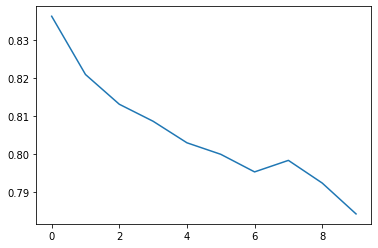

epoch = 10, average cost = 0.8052534967960202, batch_size = 16, Execution time(S) = 326.13867592811584
accuracy = 0.34


In [ ]:
print(SGD(randomTrain, randomLabels, 0.3, 10, 16, True, True))
print('accuracy = ' + str(getAccuracy(randomTrain, randomLabels)))

# Part 4: Vectorization

## Stochastic gradient descent (vectorized)

In [ ]:
def VSGD(samples, labels, learningRate, epoch, batchSize, showPlot=True, initParam=True):
  if initParam:
      initializeWeightBias()
  startTime = time.time()
  costArray = []
  for ep in range(epoch):
    shuffledSamples, shuffledLabels = unisonShuffled(samples, labels)
    for index in range(0, len(shuffledSamples), batchSize):
      sampleBatch = shuffledSamples[index:min(len(shuffledSamples), index + batchSize)]
      labelBatch = shuffledLabels[index:min(len(shuffledLabels), index + batchSize)]
      initializeGradians()
      for imageIdx in range(len(sampleBatch)):
        input = sampleBatch[imageIdx]
        label = labelBatch[imageIdx]
        _, nodes = feedforward(input, label)
        # Layer 3
        # d cost / w[2] and d cost / b[2]
        grad_w[2] += (2 * (nodes[2] - label) * nodes[2] * (1 - nodes[2])) @ np.transpose(nodes[1])
        grad_b[2] += (2 * (nodes[2] - label) * nodes[2] * (1 - nodes[2]))
        # d cost / a2
        grad_a2 = np.transpose(w[2]) @ ((2 * (nodes[2] - label)) * nodes[2] * (1 - nodes[2]))

        # Layer 2
        # d cost / w[1] and d cost / b[1]
        grad_w[1] += grad_a2 * nodes[1] * (1 - nodes[1]) @ np.transpose(nodes[0])
        grad_b[1] += grad_a2 * nodes[1] * (1 - nodes[1])
        # d cost / a1
        grad_a1 = np.transpose(w[1]) @ (grad_a2 * nodes[1] * (1 - nodes[1]))

        # Layer 1
        # d cost / w[0] and d cost / b[0]
        grad_w[0] += grad_a1 * nodes[0] * (1 - nodes[0]) @ np.transpose(input)
        grad_b[0] += grad_a1 * nodes[0] * (1 - nodes[0])

      # Update
      w[2] = w[2] - learningRate * (grad_w[2] / len(sampleBatch))
      w[1] = w[1] - learningRate * (grad_w[1] / len(sampleBatch))
      w[0] = w[0] - learningRate * (grad_w[0] / len(sampleBatch))
      b[2] = b[2] - learningRate * (grad_b[2] / len(sampleBatch))
      b[1] = b[1] - learningRate * (grad_b[1] / len(sampleBatch))
      b[0] = b[0] - learningRate * (grad_b[0] / len(sampleBatch))
    cost = getCost(shuffledSamples, shuffledLabels)
    costArray.append(cost)
  if showPlot is True:
    plt.plot([i for i in range(epoch)], costArray)
    plt.show()
  return "epoch = " + str(epoch) + ", average cost = " + \
    str(np.sum(costArray) / epoch) + \
    ", batch_size = " + str(batchSize) + \
    ", Execution time(S) = " + str((time.time() - startTime))

## Train vectorized SGD

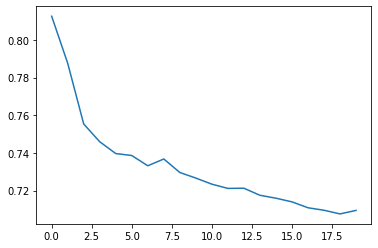

epoch = 20, average cost = 0.7328583948012161, batch_size = 16, Execution time(S) = 1.6933932304382324
accuracy = 0.42


In [ ]:
print(VSGD(randomTrain, randomLabels, 0.3, 20, 16, True, True))
print('accuracy = ' + str(getAccuracy(randomTrain, randomLabels)))

## Get accuracy after VSGD train (average of 10 iterations, each time reinitialize weights and biases)

In [ ]:
accuracy = 0
cost = 0
for i in range(0, 10):
  randomTrain, randomLabels = randomSampleLabel(200)
  VSGD(randomTrain, randomLabels, 0.3, 20, 16, False, True)
  cost += getCost(randomTrain, randomLabels)
  accuracy += getAccuracy(randomTrain, randomLabels)
print("average accuracy = " + str(accuracy / 10) + ", average cost = " + str(cost / 10))

average accuracy = 0.426, average cost = 0.6903908104037593


# Part 5: Test

Test 8000 samples for 10 times and print average accuracy and cost

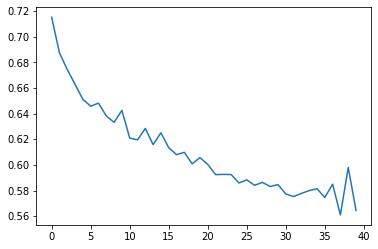

epoch = 40, average cost = 0.6103095207932251, batch_size = 16, Execution time(S) = 104.5183310508728


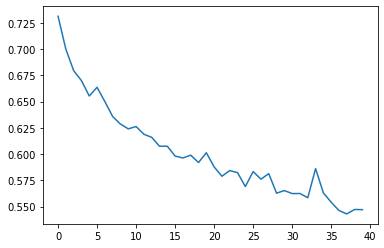

epoch = 40, average cost = 0.6009845113619205, batch_size = 16, Execution time(S) = 104.76294493675232


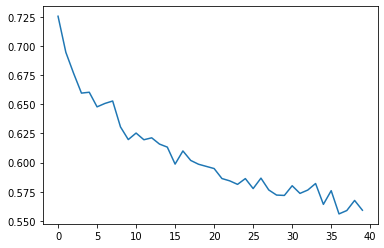

epoch = 40, average cost = 0.6057567449052496, batch_size = 16, Execution time(S) = 104.31878685951233


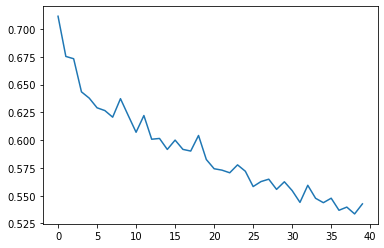

epoch = 40, average cost = 0.5897769984677754, batch_size = 16, Execution time(S) = 104.3162169456482


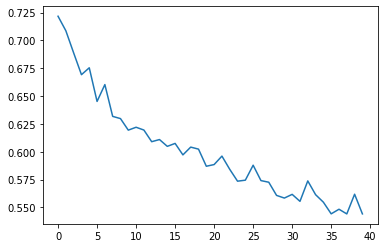

epoch = 40, average cost = 0.6008673440842712, batch_size = 16, Execution time(S) = 104.17990803718567


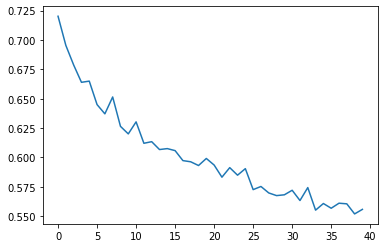

epoch = 40, average cost = 0.6018670059509359, batch_size = 16, Execution time(S) = 104.21560740470886


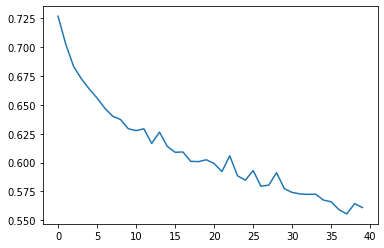

epoch = 40, average cost = 0.6088815473658523, batch_size = 16, Execution time(S) = 104.00987815856934


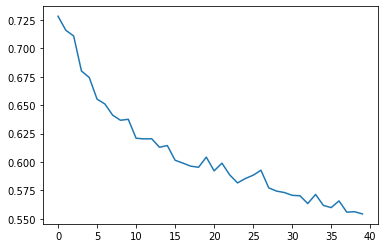

epoch = 40, average cost = 0.6074702124482103, batch_size = 16, Execution time(S) = 104.31237316131592


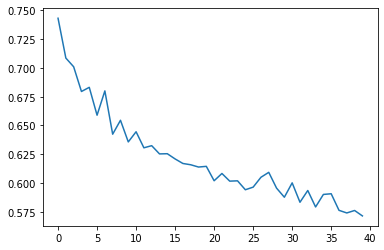

epoch = 40, average cost = 0.6216014796454824, batch_size = 16, Execution time(S) = 104.23291277885437


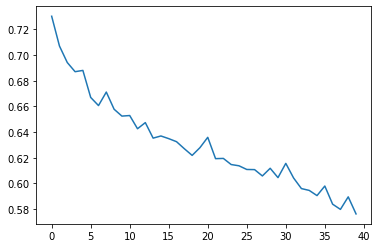

epoch = 40, average cost = 0.6312539129328604, batch_size = 16, Execution time(S) = 104.3380618095398
average train cost = 0.5576490342325133, average train accuracy = 0.5662499999999999
average test cost = 0.6301988193858126, average test accuracy = 0.49615


In [ ]:
trainCost = 0
trainAccuracy = 0
testCost = 0
testAccuracy = 0
n = 10
for i in range(n):
  randomTrain, randomLabels = randomSampleLabel(8000)
  print(VSGD(randomTrain, randomLabels, 0.3, 40, 16, True, True))
  trainCost += getCost(randomTrain, randomLabels)
  trainAccuracy += getAccuracy(randomTrain, randomLabels)
  testCost += getCost(test, testLabels)
  testAccuracy += getAccuracy(test, testLabels)
print("average train cost = " + str(trainCost / n) + ", average train accuracy = " + str(trainAccuracy / n))
print("average test cost = " + str(testCost / n) + ", average test accuracy = " + str(testAccuracy / n))

# Bonus Part 1

## Imports

In [2]:
from tensorflow import keras
from keras import datasets, layers, losses
import numpy as np
import matplotlib.pyplot as plt

## Load dataset

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

170508288/170498071 [==============================] - 3s 0us/step


In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Part 1 - 1 : Base network

In [ ]:
model1 = keras.Sequential([
                          
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax'),

])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [ ]:
model1.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history1 = model1.fit(train_images, train_labels, batch_size=50, epochs=25, validation_data=(test_images, test_labels))

Epoch 1/25
1000/1000 [==============================] - 172s 171ms/step - loss: 1.4842 - accuracy: 0.4557 - val_loss: 1.1634 - val_accuracy: 0.5787
Epoch 2/25
1000/1000 [==============================] - 172s 172ms/step - loss: 1.0404 - accuracy: 0.6322 - val_loss: 0.9889 - val_accuracy: 0.6541
Epoch 3/25
1000/1000 [==============================] - 175s 175ms/step - loss: 0.8419 - accuracy: 0.7031 - val_loss: 0.8921 - val_accuracy: 0.6910
Epoch 4/25
1000/1000 [==============================] - 175s 175ms/step - loss: 0.7093 - accuracy: 0.7482 - val_loss: 0.8411 - val_accuracy: 0.7102
Epoch 5/25
1000/1000 [==============================] - 183s 183ms/step - loss: 0.6066 - accuracy: 0.7880 - val_loss: 0.8400 - val_accuracy: 0.7183
Epoch 6/25
1000/1000 [==============================] - 185s 185ms/step - loss: 0.5298 - accuracy: 0.8146 - val_loss: 0.8720 - val_accuracy: 0.7261
Epoch 7/25
1000/1000 [==============================] - 182s 182ms/step - loss: 0.4457 - accuracy: 0.8444 - val_

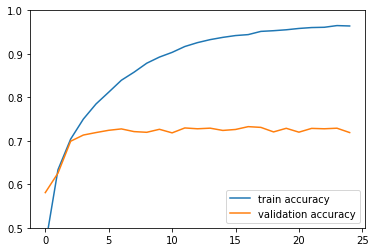

In [ ]:
plt.plot(history1.history['accuracy'], label='train accuracy')
plt.plot(history1.history['val_accuracy'], label='validation accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Part 1 - 2 : Adding batch normalization

In [ ]:
model2 = keras.Sequential([
                          
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax'),

])

In [ ]:
model2.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history2 = model2.fit(train_images, train_labels, batch_size=50, epochs=25, validation_data=(test_images, test_labels))

Epoch 1/25
1000/1000 [==============================] - 10s 9ms/step - loss: 1.3760 - accuracy: 0.5091 - val_loss: 1.1223 - val_accuracy: 0.6016
Epoch 2/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.9552 - accuracy: 0.6606 - val_loss: 1.1186 - val_accuracy: 0.6230
Epoch 3/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.7785 - accuracy: 0.7283 - val_loss: 0.9553 - val_accuracy: 0.6739
Epoch 4/25
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6572 - accuracy: 0.7718 - val_loss: 0.8247 - val_accuracy: 0.7181
Epoch 5/25
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5549 - accuracy: 0.8091 - val_loss: 0.9376 - val_accuracy: 0.6888
Epoch 6/25
1000/1000 [==============================] - 8s 8ms/step - loss: 0.4682 - accuracy: 0.8376 - val_loss: 0.7953 - val_accuracy: 0.7393
Epoch 7/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.3879 - accuracy: 0.8667 - val_loss: 0.8412 - val_accuracy

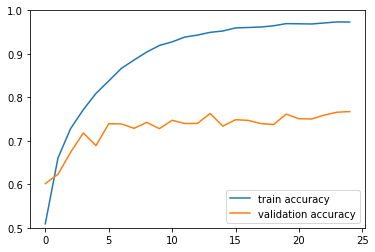

In [ ]:
plt.plot(history2.history['accuracy'], label='train accuracy')
plt.plot(history2.history['val_accuracy'], label='validation accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Part 1 - 3 : Adding dropout

In [8]:
model3 = keras.Sequential([
                          
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax'),

])

In [9]:
model3.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history3 = model3.fit(train_images, train_labels, batch_size=50, epochs=25, validation_data=(test_images, test_labels))

Epoch 1/25
1000/1000 [==============================] - 9s 8ms/step - loss: 1.8592 - accuracy: 0.3341 - val_loss: 1.5942 - val_accuracy: 0.4284
Epoch 2/25
1000/1000 [==============================] - 7s 7ms/step - loss: 1.4371 - accuracy: 0.4765 - val_loss: 1.4460 - val_accuracy: 0.4930
Epoch 3/25
1000/1000 [==============================] - 7s 7ms/step - loss: 1.2473 - accuracy: 0.5547 - val_loss: 1.1305 - val_accuracy: 0.5952
Epoch 4/25
1000/1000 [==============================] - 7s 7ms/step - loss: 1.1085 - accuracy: 0.6117 - val_loss: 1.4092 - val_accuracy: 0.5311
Epoch 5/25
1000/1000 [==============================] - 8s 8ms/step - loss: 1.0148 - accuracy: 0.6473 - val_loss: 0.8907 - val_accuracy: 0.6896
Epoch 6/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.9465 - accuracy: 0.6754 - val_loss: 0.8360 - val_accuracy: 0.7154
Epoch 7/25
1000/1000 [==============================] - 7s 7ms/step - loss: 0.8901 - accuracy: 0.6956 - val_loss: 1.0003 - val_accuracy:

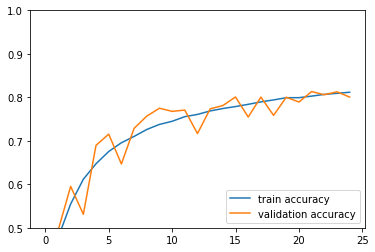

In [10]:
plt.plot(history3.history['accuracy'], label='train accuracy')
plt.plot(history3.history['val_accuracy'], label='validation accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Part 1 - 4 : Optimizers

##  Optimizers 1 : SGD

In [ ]:
model4 = keras.Sequential([
                          
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax'),

])

In [ ]:
model4.compile(optimizer='SGD', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history4 = model4.fit(train_images, train_labels, batch_size=50, epochs=25, validation_data=(test_images, test_labels))

Epoch 1/25
1000/1000 [==============================] - 18s 7ms/step - loss: 2.1996 - accuracy: 0.2413 - val_loss: 1.7438 - val_accuracy: 0.3455
Epoch 2/25
1000/1000 [==============================] - 7s 7ms/step - loss: 1.7868 - accuracy: 0.3345 - val_loss: 1.5729 - val_accuracy: 0.4029
Epoch 3/25
1000/1000 [==============================] - 7s 7ms/step - loss: 1.6514 - accuracy: 0.3815 - val_loss: 1.5252 - val_accuracy: 0.4237
Epoch 4/25
1000/1000 [==============================] - 7s 7ms/step - loss: 1.5718 - accuracy: 0.4159 - val_loss: 1.4768 - val_accuracy: 0.4486
Epoch 5/25
1000/1000 [==============================] - 7s 7ms/step - loss: 1.5100 - accuracy: 0.4414 - val_loss: 1.4762 - val_accuracy: 0.4456
Epoch 6/25
1000/1000 [==============================] - 6s 6ms/step - loss: 1.4664 - accuracy: 0.4596 - val_loss: 1.5514 - val_accuracy: 0.4388
Epoch 7/25
1000/1000 [==============================] - 7s 7ms/step - loss: 1.4254 - accuracy: 0.4772 - val_loss: 1.3351 - val_accuracy

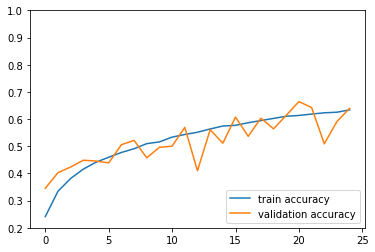

In [ ]:
plt.plot(history4.history['accuracy'], label='train accuracy')
plt.plot(history4.history['val_accuracy'], label='validation accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

##  Optimizers 2 : RMSprop

In [ ]:
model5 = keras.Sequential([
                          
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax'),

])

In [ ]:
model5.compile(optimizer='RMSprop', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history5 = model5.fit(train_images, train_labels, batch_size=50, epochs=25, validation_data=(test_images, test_labels))

Epoch 1/25
1000/1000 [==============================] - 12s 10ms/step - loss: 1.7940 - accuracy: 0.3612 - val_loss: 1.4398 - val_accuracy: 0.4832
Epoch 2/25
1000/1000 [==============================] - 8s 8ms/step - loss: 1.2933 - accuracy: 0.5373 - val_loss: 1.2475 - val_accuracy: 0.5572
Epoch 3/25
1000/1000 [==============================] - 8s 8ms/step - loss: 1.1136 - accuracy: 0.6073 - val_loss: 1.1801 - val_accuracy: 0.5796
Epoch 4/25
1000/1000 [==============================] - 8s 8ms/step - loss: 1.0110 - accuracy: 0.6463 - val_loss: 0.9188 - val_accuracy: 0.6827
Epoch 5/25
1000/1000 [==============================] - 8s 8ms/step - loss: 0.9385 - accuracy: 0.6772 - val_loss: 0.9645 - val_accuracy: 0.6642
Epoch 6/25
1000/1000 [==============================] - 8s 8ms/step - loss: 0.8766 - accuracy: 0.7014 - val_loss: 0.8976 - val_accuracy: 0.6961
Epoch 7/25
1000/1000 [==============================] - 8s 8ms/step - loss: 0.8413 - accuracy: 0.7148 - val_loss: 0.8360 - val_accurac

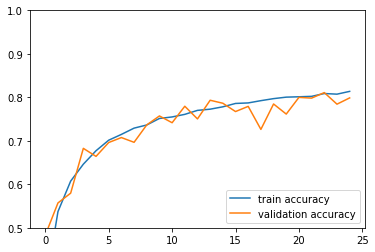

In [ ]:
plt.plot(history5.history['accuracy'], label='train accuracy')
plt.plot(history5.history['val_accuracy'], label='validation accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

##  Optimizers 3 : Nadam

In [ ]:
model_nadam = keras.Sequential([
                          
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax'),

])

In [ ]:
model_nadam.compile(optimizer='Nadam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history_nadam = model_nadam.fit(train_images, train_labels, batch_size=50, epochs=25, validation_data=(test_images, test_labels))

Epoch 1/25
1000/1000 [==============================] - 46s 43ms/step - loss: 1.8797 - accuracy: 0.3300 - val_loss: 1.5286 - val_accuracy: 0.4344
Epoch 2/25
1000/1000 [==============================] - 42s 42ms/step - loss: 1.4402 - accuracy: 0.4741 - val_loss: 1.4196 - val_accuracy: 0.4856
Epoch 3/25
1000/1000 [==============================] - 42s 42ms/step - loss: 1.2654 - accuracy: 0.5466 - val_loss: 1.0809 - val_accuracy: 0.6086
Epoch 4/25
1000/1000 [==============================] - 42s 42ms/step - loss: 1.1456 - accuracy: 0.5952 - val_loss: 1.0907 - val_accuracy: 0.6094
Epoch 5/25
1000/1000 [==============================] - 42s 42ms/step - loss: 1.0454 - accuracy: 0.6359 - val_loss: 0.8684 - val_accuracy: 0.6922
Epoch 6/25
1000/1000 [==============================] - 42s 42ms/step - loss: 0.9770 - accuracy: 0.6614 - val_loss: 0.8447 - val_accuracy: 0.7040
Epoch 7/25
1000/1000 [==============================] - 41s 41ms/step - loss: 0.9205 - accuracy: 0.6839 - val_loss: 0.8272 -

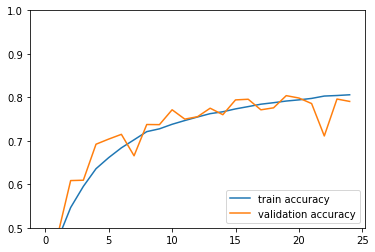

In [ ]:
plt.plot(history_nadam.history['accuracy'], label='train accuracy')
plt.plot(history_nadam.history['val_accuracy'], label='validation accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Precision, Recall, F1 for model3 (best model above 80%)

precision: 0.8060029316095292
reacll: 0.8006
f1 score: 0.7965117140793188


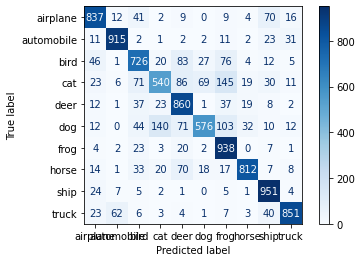

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred1 = model3.predict(test_images)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
print('precision: '+ str(precision_score(test_labels, y_pred , average="macro")))
print('reacll: ' + str(recall_score(test_labels, y_pred , average="macro")))
print('f1 score: ' +str(f1_score(test_labels, y_pred , average="macro")))
# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Bonus Part 2

## Bonus Part 2 - 1: Explain data augmentation (In PDF)

## Bonus Part 2 - 2: Data augmentation

In [12]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array

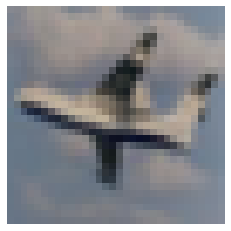

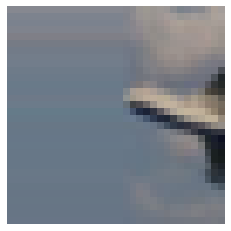

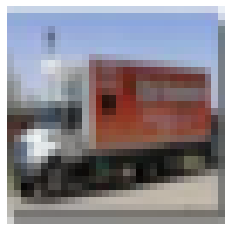

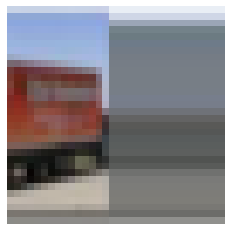

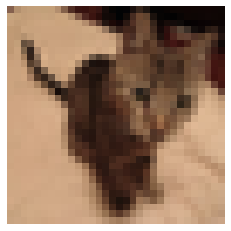

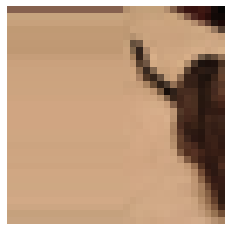

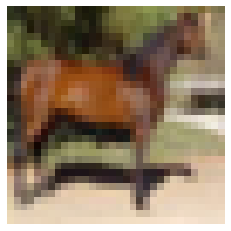

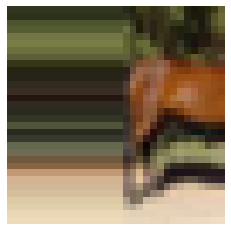

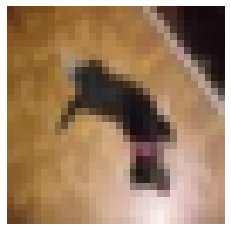

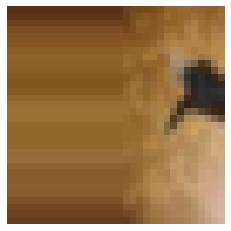

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip = True)

datagen = ImageDataGenerator(width_shift_range=[-16,16])

for i in range(5):
  image_raw = train_images[np.random.randint(20000)]
  image_array = img_to_array(image_raw)
  image_exp = np.expand_dims(image_array, 0)
  it = datagen.flow(image_exp, batch_size=1)
  batch = it.next()
  image = batch[0]
  plt.imshow(image_raw)
  plt.axis("off")
  plt.show()
  plt.imshow(image)
  plt.axis("off")
  plt.show()

## Bonus Part 2 - 3: Deleting 90% of cats and dogs

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def get500(x, y):
  randomIdx = np.random.randint(5000, size=500)
  randomTrain = x[randomIdx, :]
  randomLabels = y[randomIdx, :]
  return randomTrain, randomLabels

cat_images = train_images[3 * 5000: 4 * 5000]
cat_labels = train_labels[3 * 5000: 4 * 5000]
dog_images = train_images[5 * 5000: 6 * 5000]
dog_labels = train_labels[5 * 5000: 6 * 5000]
cat_images_500, cat_labels_500 = get500(cat_images, cat_labels)
dog_images_500, dog_labels_500 = get500(cat_images, cat_labels)

temp1 = np.append(np.delete(train_images,np.s_[3 * 5000: 4 * 5000],axis=0), cat_images_500, axis=0)
temp2 = np.append(np.delete(train_labels,np.s_[3 * 5000: 4 * 5000],axis=0), cat_labels_500, axis=0)
new_train_images = np.append(np.delete(temp1,np.s_[4 * 5000: 5 * 5000],axis=0), dog_images_500, axis=0)
new_train_labels = np.append(np.delete(temp2,np.s_[4 * 5000: 5 * 5000],axis=0), dog_labels_500, axis=0)

In [ ]:
model6 = keras.Sequential([
                          
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax'),

])

In [ ]:
model6.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history6 = model6.fit(new_train_images, new_train_labels, batch_size=50, epochs=25, validation_data=(test_images, test_labels))

Epoch 1/25
820/820 [==============================] - 7s 7ms/step - loss: 1.9471 - accuracy: 0.3099 - val_loss: 1.5046 - val_accuracy: 0.4484
Epoch 2/25
820/820 [==============================] - 5s 7ms/step - loss: 1.4946 - accuracy: 0.4523 - val_loss: 1.3093 - val_accuracy: 0.5275
Epoch 3/25
820/820 [==============================] - 6s 7ms/step - loss: 1.3218 - accuracy: 0.5260 - val_loss: 1.2319 - val_accuracy: 0.5603
Epoch 4/25
820/820 [==============================] - 5s 7ms/step - loss: 1.2055 - accuracy: 0.5704 - val_loss: 1.1399 - val_accuracy: 0.5896
Epoch 5/25
820/820 [==============================] - 5s 7ms/step - loss: 1.1111 - accuracy: 0.6088 - val_loss: 0.9918 - val_accuracy: 0.6506
Epoch 6/25
820/820 [==============================] - 6s 7ms/step - loss: 1.0298 - accuracy: 0.6400 - val_loss: 1.0209 - val_accuracy: 0.6513
Epoch 7/25
820/820 [==============================] - 5s 7ms/step - loss: 0.9660 - accuracy: 0.6639 - val_loss: 0.9524 - val_accuracy: 0.6609
Epoch 

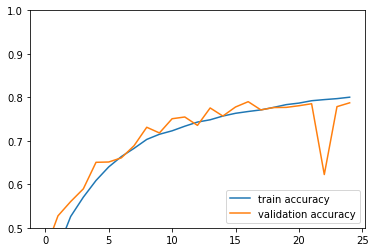

In [ ]:
plt.plot(history6.history['accuracy'], label='train accuracy')
plt.plot(history6.history['val_accuracy'], label='validation accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

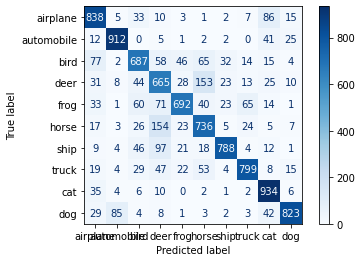

In [ ]:
y_pred1 = model6.predict(test_images)
y_pred = np.argmax(y_pred1, axis=1)
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['airplane', 'automobile', 'bird', 'deer', 'frog', 'horse', 'ship', 'truck', 'cat', 'dog'])
disp.plot(cmap=plt.cm.Blues)
plt.show()